In [1]:
import os 
os.chdir(os.path.dirname(os.getcwd()))
print("Current Working Directory " , os.getcwd())

Current Working Directory  c:\Users\braya\Documents\github\colibri-hdsp


Demo CASSI Reconstruction

In [2]:
#General imports
import matplotlib.pyplot as plt
import torch
import os

manual_device = "cpu"
# Check GPU support
print("GPU support: ", torch.cuda.is_available())

if manual_device:
    device = manual_device
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU support:  True


Load Dataset

In [3]:
from colibri.data.datasets import Dataset

# Load dataset

dataset_path = 'cifar10'
keys = ''
batch_size = 128

dataset = Dataset(dataset_path, keys, batch_size)

adquistion_name = 'cassi' #  ['spc', 'cassi']

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


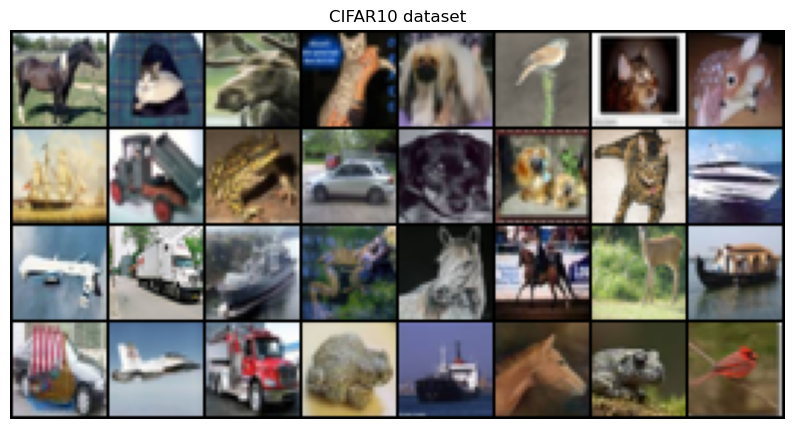

In [4]:
# import make_grid from torchvision
from torchvision.utils import make_grid

sample = next(iter(dataset.train_dataset))[0]

img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

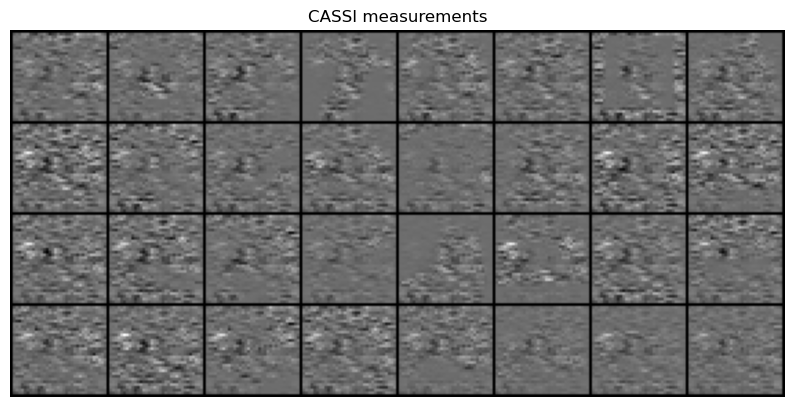

In [5]:
import math
from colibri.optics import SPC, CASSI

img_size = sample.shape[1:]

acquisition_config = dict(
    input_shape = img_size,
)

if adquistion_name == 'spc':
    n_measurements  = 256 
    n_measurements_sqrt = int(math.sqrt(n_measurements))    
    acquisition_config['n_measurements'] = n_measurements

acquistion_model = {
    'spc': SPC(**acquisition_config),
    'cassi': CASSI(**acquisition_config),
}[adquistion_name]

y = acquistion_model(sample)

if adquistion_name == 'spc':
    y = y.reshape(y.shape[0], -1, n_measurements_sqrt, n_measurements_sqrt)


img = make_grid(y[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'{adquistion_name.upper()} measurements')
plt.show()


Build Model

In [6]:
from colibri.models import build_network, Unet, Autoencoder
from colibri.archs import E2E
from colibri.train import Training
from colibri.metrics import psnr, ssim
from colibri.regularizers import (
    Reg_Binary,
    Reg_Transmittance,
    MinVariance,
    KLGaussian,
)


network_config = dict(
    in_channels=sample.shape[1],
    out_channels=sample.shape[1],
    reduce_spatial = True           # Only for Autoencoder
)

recovery_model = build_network(Unet, **network_config)

model = E2E(acquistion_model, recovery_model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = {"MSE": torch.nn.MSELoss(), "L1": torch.nn.L1Loss()}
metrics = {"PSNR": psnr, "SSIM": ssim}
losses_weights = [1.0, 1.0]

n_epochs = 10
steps_per_epoch = 10
frequency = 1
regularizers_optics_ce = {"RB": Reg_Binary(), "RT": Reg_Transmittance()}
regularizers_optics_ce_weights = [50, 1]

regularizers_optics_mo = {"MV": MinVariance(), "KLG": KLGaussian(stddev=0.1)}
regularizers_optics_mo_weights = [1e-3, 0.1]

train_schedule = Training(
    model=model,
    train_loader=dataset.train_dataset,
    optimizer=optimizer,
    loss_func=losses,
    losses_weights=losses_weights,
    metrics=metrics,
    regularizers=None,
    regularization_weights=None,
    schedulers=[],
    callbacks=[],
    device=device,
    regularizers_optics_ce=regularizers_optics_ce,
    regularization_optics_weights_ce=regularizers_optics_ce_weights,
    regularizers_optics_mo=regularizers_optics_mo,
    regularization_optics_weights_mo=regularizers_optics_mo_weights,
)


results = train_schedule.fit(
    n_epochs=n_epochs, steps_per_epoch=steps_per_epoch, freq=frequency
)

Train :: Epoch: 10/10:   3%|▎         | 11/391 [00:08<05:03,  1.25it/s, s=MSE: 6.49E-03, L1: 5.67E-02, , RB: 1.89E+06, RT: 6.15E+00, , MV: 1.33E-02, KLG: 4.78E+00,]


Training Loop

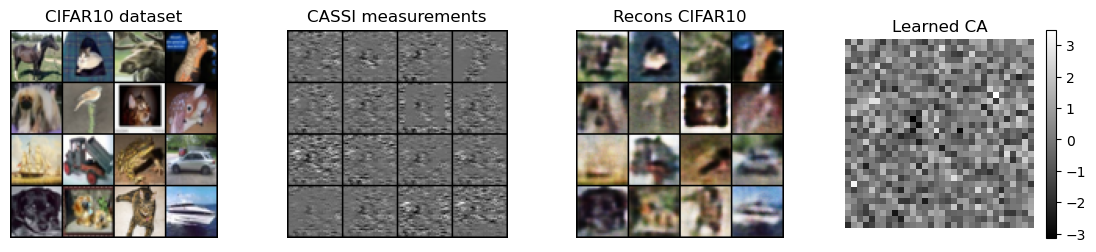

In [7]:
x_est = model(sample.to(device)).cpu()
y = acquistion_model(sample.to(device)).cpu()

if adquistion_name == 'spc':
    y = y.reshape(y.shape[0], -1, n_measurements_sqrt, n_measurements_sqrt)

img      = make_grid(sample[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_est  = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_y    = make_grid(y[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

imgs_dict = {
    "CIFAR10 dataset": img, 
    f"{adquistion_name.upper()} measurements": img_y,
    "Recons CIFAR10": img_est
}

plt.figure(figsize=(14, 2.7))

for i, (title, img) in enumerate(imgs_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

if adquistion_name == 'spc':
    ca = acquistion_model.ca.reshape(n_measurements, 32, 32, 1).cpu().detach().numpy().squeeze()[0]
elif adquistion_name == 'cassi':
    ca = acquistion_model.ca.cpu().detach().numpy().squeeze()

plt.subplot(1, 4, 4)
plt.imshow(ca, cmap='gray')
plt.axis('off')
plt.title('Learned CA')
plt.colorbar()

plt.show()